In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import os
from sklearn.mixture import GaussianMixture

%matplotlib inline
rcParams['figure.facecolor'] = 'white'


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/gridware/depots/724a72d3/el8/pkg/apps/anaconda3/2023.03/bin/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/gridware/depots/724a72d3/el8/pkg/apps/anaconda3/2023.03/bin/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/gridware/depots/724a72d3/el8/pkg/apps/anaconda3/2023.03/bin/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/gridware/d

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/gridware/depots/724a72d3/el8/pkg/apps/anaconda3/2023.03/bin/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/gridware/depots/724a72d3/el8/pkg/apps/anaconda3/2023.03/bin/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/gridware/depots/724a72d3/el8/pkg/apps/anaconda3/2023.03/bin/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/gridware/d

AttributeError: _ARRAY_API not found

In [11]:
def get_metallicity_functions(simulation, snapshot=127, subdir='/output/', age_intermediate=6., age_old=10.):
    print('Loading simulation: '+simulation)
    sf = load_subfind(snapshot, dir=simulation+subdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=simulation+subdir, subfind=sf, hdf5=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    galrad = 0.25 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    outer_radius = 1e3*galrad
    
    element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
    elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
    #from Asplund et al. (2009) Table 5
    SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
    for iel,val in enumerate(element):
        s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
        s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

    s.data['Z/H'] = np.log10(s.data['gz']/0.0127)
    
    starparts = (s.data['age'] > 0) * (s.r()[s.data['type']==4]<galrad)
    
    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    Gcosmo = 43.
    
    kinetic_energy = np.sum(s.data['vel']**2, axis=1)

    orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
    orbital_energy /= 1e5
    
    Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]

    parts_radius = s.r()
    isort_parts = np.argsort(parts_radius)
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

    # Energy of circular orbits at increasing radii
    Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
    Ecirc /= 1e5
    e_max = np.nanmax(Ecirc[~np.isinf(Ecirc)])
    orbital_energy -= e_max
    Ecirc -= e_max
    
    jz = Lz[s.data['type']==4][starparts]
    ii = np.argsort(orbital_energy[s.data['type']==4][starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1

    
    # Build feature array: [ε, Energy]
    X = np.vstack((eps,orbital_energy[s.data['type']==4][starparts],
                    np.log10(np.abs(s.data['pos'][:,0][s.data['type']==4][starparts])))).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[s.data['type']==4][starparts]), -1.5],
                                                        [0.9,np.median(orbital_energy[s.data['type']==4][starparts]), -2.5]],
                                                        covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomp_labels = gmm.predict(X)
    median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
    sph_label = np.argmin(median_eps)
    disc_label = np.argmax(median_eps)

    #Force assign disc_label to clusters with high circularity
    mask = (decomp_labels == sph_label) & (eps > 0.7)
    decomp_labels[mask] = disc_label

    feh_scs = np.repeat(s.data['Fe/H'][starparts][decomp_labels == sph_label], s.data['nclt'][starparts][decomp_labels == sph_label])
    feh_scs_i = np.repeat(s.data['Fe/H'][starparts][decomp_labels == sph_label], s.data['incl'][starparts][decomp_labels == sph_label])
    mclus_i = s.data['imcl'][starparts][decomp_labels == sph_label].flatten()
    mclus_m = s.data['mclt'][starparts][decomp_labels == sph_label].flatten()
    mclus_m = mclus_m[mclus_i>0]*1e10
    mclus_i = mclus_i[mclus_i>0]*1e10
    clus_age = np.repeat(s.cosmology_get_lookback_time_from_a(s.data['age'][starparts][decomp_labels==sph_label], is_flat=True)
                          - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True), s.data['nclt'][starparts][decomp_labels == sph_label])
    gc_cand_i = (mclus_i > 1e5)
    gc_cand_6 = (mclus_i[mclus_m>0] > 1e5) * (clus_age > 8.)
    gc_cand_10 = (mclus_i[mclus_m>0] > 1e5) * (clus_age > 10.)

    N, binw = np.histogram(feh_scs_i, bins=20, range=[-3,1])
    width = np.diff(binw)
    initial_mdf = N/width
    N,binw = np.histogram(feh_scs[gc_cand_6], bins=20, range=[-3,1])
    intermediate_age_mdf = N/width
    N,binw = np.histogram(feh_scs[gc_cand_10], bins=20, range=[-3,1])
    old_age_mdf = N/width
    
    return [initial_mdf, intermediate_age_mdf, old_age_mdf]

In [8]:
dir = './'
# simulation_list = [directory for directory in os.listdir(dir) if 'Au6_lvl4' in directory]
# print(simulation_list)
simulation_list = ['Au6_lvl4_d8ad_fiducial', 'Au18_lvl4_d8ad_drh0', 'Au27_lvl4_7ac0_fiducial']

In [4]:
m31_metallicity = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=8, delimiter=',')
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_metallicity = mw_catalogue[:,0]

In [5]:
initial_mdf = []
intermediate_mdf = []
old_mdf = []

In [13]:
for sim in simulation_list:
    initial, intermediate, old = get_metallicity_functions(sim, snapshot=123, age_intermediate=8, age_old=10)
    initial_mdf.append(initial)
    intermediate_mdf.append(intermediate)
    old_mdf.append(old)

Loading simulation: Au6_lvl4_d8ad_fiducial
galrad= 0.021103246
Found 1379362 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.05


/tmp/ipykernel_3244386/3474767365.py:15: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3244386/3474767365.py:18: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Loading simulation: Au18_lvl4_d8ad_drh0
galrad= 0.021961527
Found 2218975 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3244386/3474767365.py:15: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3244386/3474767365.py:18: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.05
Loading simulation: Au27_lvl4_7ac0_fiducial
galrad= 0.025182446
Found 2557399 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_3244386/3474767365.py:15: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_3244386/3474767365.py:18: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


Redshift of the simulation: 0.05


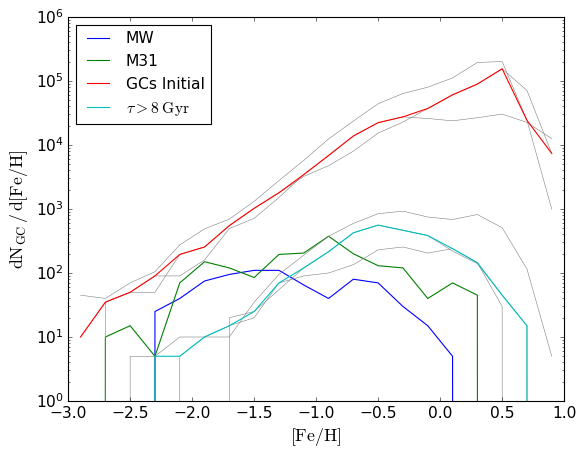

In [20]:
N, binw = np.histogram(mw_metallicity, bins=20, range=[-3,1])
width = np.diff(binw)
plot_xarray = (binw[1:]+binw[:-1])/2.
plt.plot(plot_xarray, N/width, label='MW')
N, binw = np.histogram(m31_metallicity, bins=20, range=[-3,1])
plt.plot(plot_xarray, N/width, label='M31')

for i in range(len(simulation_list)):
    plt.plot(plot_xarray, initial_mdf[i], linewidth=0.5, color='grey')
    plt.plot(plot_xarray, intermediate_mdf[i], linewidth=0.5, color='grey')
    # plt.plot(plot_xarray, old_mdf[i], linewidth=0.5, color='grey')

plt.plot(plot_xarray, np.median(np.array(initial_mdf), axis=0), label='GCs Initial')
plt.plot(plot_xarray, np.median(np.array(intermediate_mdf), axis=0), label=r'$\tau > 8 \;\rm{Gyr}$')
# plt.plot(plot_xarray, np.median(np.array(old_mdf), axis=0), label=r'$\tau > 10 \;\rm{Gyr}$')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel(r'$\rm{[Fe/H]}$', fontsize=16)
plt.ylabel(r'$\rm{d}N_{\rm{GC}} \, / \, \rm{d} [\rm{Fe/H}]$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
